In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
# %% load packages
import locale
import sys
import os
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import optuna
import requests
import torch
import random
from sqlalchemy import create_engine,inspect
from pathlib import Path
import urllib.parse
import pyarrow
from calendar import day_abbr
import calendar
from typing import Tuple, Union, Dict, List

In [ ]:
from srs.utils.tutor_utils import prepare_dataset_tensor, forecasting_study,\
  plot_daily_profile,plot_hour_comparison, build_multiwindow_experts, tune_ewa_eta, \
  ewa_aggregate_forecasts, compute_error_table, tune_expert_window, \
  run_expert_window_test, build_regression_matrix, SimpleMLP, train_mlp, \
  prepare_train_test_tensors, build_mlp_rolling_forecasts, tune_mlp_hyperparameters 
  
  
from srs.collect_data.setup import setup_seed, get_device
from srs.collect_data.entsoe_data import create_entsoe_engine, get_tables, get_spec, \
  get_market_divisions,get_map_codes,get_map_codes_starting_with, get_resolution_codes, \
    prepare_generation, prepare_load,prepare_price, prepare_unavailability, \
    prepare_filling_rate_hydro, prepare_physical_flow, prepare_installed_capacity
from srs.collect_data.datastream_data import create_datastream_engine, get_tables, \
  prepare_datastream
from srs.collect_data.dwd_mosmix_data import fetch_region_weather, prepare_weather
from srs.collect_data.merge_data import merge_datasets, build_training_dataset



In [4]:
# 1. utils.py
setup_seed(42)
device = get_device()
print("Device used:", device)


Device used: cpu


In [5]:
# 2. entsoe_data.py
# create engine and load spec
engine = create_entsoe_engine()
tables = get_tables(engine)
spec = get_spec(engine)
print("Tables in ENTSOE:", tables)

market_divisions = get_market_divisions(spec)
map_code = get_map_codes(spec)
map_code_norway = get_map_codes_starting_with(spec, 'NO')
print("All regions map code:", map_code.tolist())
print("Market divisions:", market_divisions)
print("Norway map code:", map_code_norway)

resolution = get_resolution_codes(spec)
print("Resolution code:", resolution)

Tables in ENTSOE: ['ProductionAndGenerationUnits', 'importlog', 'spec', 'vals']
All regions map code: ['PL', 'UA_IPS', 'RS', 'RO', 'HU', 'BG', 'MD', 'AT', 'SI', 'DE_Amprion', 'CZ', 'DE_TenneT_GER', 'DE_TransnetBW', 'CH', 'IT', 'UA', 'DE', 'DE_LU', 'IT-NORTH', 'GB', 'NO2', 'NO', 'ES', 'FR', 'PT', 'LT', 'SK', 'SE4', 'DE_50HzT', 'SE', 'SE2', 'NO4', 'DK2', 'SE3', 'NO1', 'NO3', 'EE', 'FI', 'NO5', 'DK1', 'NL', 'DK', 'SE1', 'BE', 'UA_DobTPP', 'AL', 'BA', 'ME', 'GR', 'XK', 'IT-CSOUTH', 'MK', 'GB_IFA2', 'GB_IFA', 'GB_ElecLink', 'IT-Calabria', 'IT-SACODC', 'IT-SACOAC', 'IT-CNORTH', 'IT-Sardinia', 'IT-Sicily', 'IT-SOUTH', 'HR', 'LV', 'RU_KGD', 'BY', 'RU', 'LU', 'GE', 'TR', 'AM', 'AZ', 'NIE', 'IE', 'IE_SEM', 'MT', 'UA_BEI', 'IT_NORD_FR', 'IT-Rossano', 'IT-Priolo', 'IT-Brindisi', 'IT-Foggia', 'DE_AT_LU', 'CY', 'NO2NSL', 'IT_NORD_AT', 'IT_NORD_SI', 'IT_NORD_CH', 'IT_GR', 'IT_SICI_MT', None, 'CZ_DE_SK', 'NO2A', 'NO1A', 'DK1-NO1', 'PL_CZ', 'SE3A']
Market divisions: ['CTA' 'BZN' 'CTY' 'BZN/CTA']
Norway

In [6]:
# 3. entsoe_data
# download data as Polars dataset
gen_pl = prepare_generation(spec, engine)
load_pl = prepare_load(spec, engine)
price_pl = prepare_price(spec, engine)
fill_pl =  prepare_filling_rate_hydro(spec, engine)
flow_pl =  prepare_physical_flow(spec, engine)
cap_pl = prepare_installed_capacity(spec, engine)
unav_pl = prepare_unavailability(spec, engine)

In [14]:
# 4. datastream data
# downlaod data as Polars dataset
ds_engine = create_datastream_engine()
ds_tables = get_tables(ds_engine)
fuel_pl = prepare_datastream(ds_engine)

In [15]:
# 5. dwd_mosmix data
weather_pl = prepare_weather()

In [16]:
weather_pl['MapCode'].unique()

MapCode
str
"""NO1"""
"""NO3"""
"""NO4"""
"""NO5"""
"""NO2"""


In [10]:
load_pl.columns

['MapCode', 'time_utc', 'Load_A', 'Load_DA']

In [ ]:
print("generation lenght:",len(gen_pl))
print("load length:",len(load_pl))
print("price length:",len(price_pl))
print("filling rate hyrdo length:",len(fill_pl))
print("physical flow lentght:",len(flow_pl))
print("installed capacity length:",len(cap_pl))
print("unavailability length:",len(unav_pl))
print("weather length:",len(weather_pl))

generation lenght: 263035
load length: 263040
price length: 263040
filling rate hyrdo length: 1565
physical flow lentght: 263008
installed capacity length: 6
unavailability length: 28728
weather length: 263040


In [26]:
# 6. Merge all datasets
merged_pl = merge_datasets(
    price=price_pl,
    load=load_pl,
    generation=gen_pl,
    fuels=fuel_pl,
)

repo_root = Path.cwd().parents[1]

train_df = build_training_dataset(
    merged=merged_pl,
    mapcode="NO5",               
    save_csv= repo_root / "data" / "data_no5.csv",
)

#print(train_df.head())

In [15]:
print(f"merged dataset: {train_df.columns}")

merged dataset: Index(['time_utc', 'Price', 'Load_A', 'Load_DA', 'WindOn_DA', 'WindOff_DA',
       'Solar_DA', 'Coal', 'NGas', 'Oil', 'EUA'],
      dtype='object')


In [16]:
# all columns names from each dataset
datasets = {
    "Generation data (gen_pl)": gen_pl,
    "Electricity consumption/load data (load_pl)": load_pl,
    "Day-ahead market electricity price data (price_pl)": price_pl,
    "Reservoir filling rate for hydro storage (fill_pl)": fill_pl,
    "Measured cross-border or regional physical electricity flow (flow_pl)": flow_pl,
    "Installed capacity data (cap_pl)": cap_pl,
    "Unavailability data (unav_pl)": unav_pl,
}

for name, df in datasets.items():
  print(f"{name}: {df.columns}")
  

Generation data (gen_pl): ['MapCode', 'time_utc', 'Hydro_Pumped_Storage_A', 'Hydro_Run-of-river_and_poundage_A', 'Hydro_Water_Reservoir_A', 'Solar_A', 'Wind_Onshore_A', 'Solar_DA', 'Wind_Offshore_DA', 'Wind_Onshore_DA']
Electricity consumption/load data (load_pl): ['MapCode', 'time_utc', 'Load_A', 'Load_DA']
Day-ahead market electricity price data (price_pl): ['MapCode', 'time_utc', 'Price']
Reservoir filling rate for hydro storage (fill_pl): ['time_utc', 'FillingRateHydro', 'MapCode']
Measured cross-border or regional physical electricity flow (flow_pl): ['MapCode', 'time_utc', 'PhysicalFlow']
Installed capacity data (cap_pl): ['time_utc', 'Biomass_InstCapac', 'Fossil_Brown_coal/Lignite_InstCapac', 'Fossil_Coal-derived_gas_InstCapac', 'Fossil_Gas_InstCapac', 'Fossil_Hard_coal_InstCapac', 'Fossil_Oil_InstCapac', 'Fossil_Oil_shale_InstCapac', 'Fossil_Peat_InstCapac', 'Geothermal_InstCapac', 'Hydro_Pumped_Storage_InstCapac', 'Hydro_Run-of-river_and_poundage_InstCapac', 'Hydro_Water_Reser

In [ ]:
# 7. Transform merged dataset using DST_trafo and prepare training data.
repo_root = Path.cwd().parents[1]
data_t, train_t, train_dates, price_t = prepare_dataset_tensor(
    repo_root / "data" / "data_no1_dst.csv",
    tz="CET",
    seed=42,
    test_days=2*365,         
    dtype=torch.float64, 
)
print(train_t.shape, price_t.shape)

torch.Size([1463, 24, 10]) torch.Size([1463, 24])


In [5]:
# 8. Tutorial 1
# We still need the *full* local-time date index and the column names:
df        = pd.read_csv("./data/data_no1.csv")
dates_s   = pd.to_datetime(df["time_utc"], utc=True).dt.tz_convert("CET")
reg_names = list(df.columns[1:])          


# Walk-forward forecasting study
forecasts = forecasting_study(
    data_t     = data_t,
    dates_s    = pd.Series(dates_s),
    reg_names  = reg_names,
    length_eval= 2*365,              
    history_days = 730,              
    save_path  = "OLS/forecasting_study.pt"
)

print("Forecast tensor saved – shape:", forecasts.shape)
                            

-> 100.0%  done
Forecast tensor saved – shape: torch.Size([730, 24, 2])


In [50]:
print(data_t.isnan().sum().sum())
print(train_t.isnan().sum().sum())
print(price_t.isnan().sum().sum())
print(train_dates.isna().sum().sum())

tensor(290)
tensor(60)
tensor(1)
0


<Axes: title={'center': 'Daily profile – obs 729'}, xlabel='Hour', ylabel='Price'>

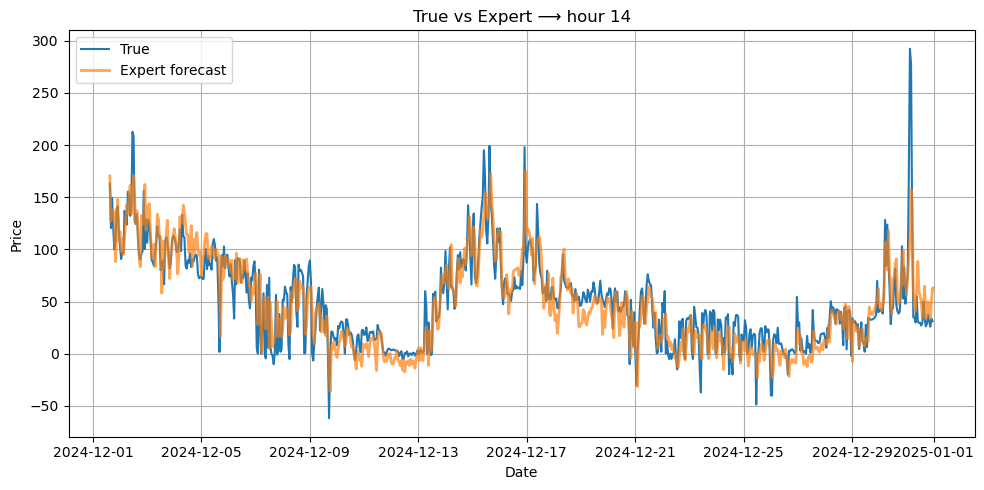

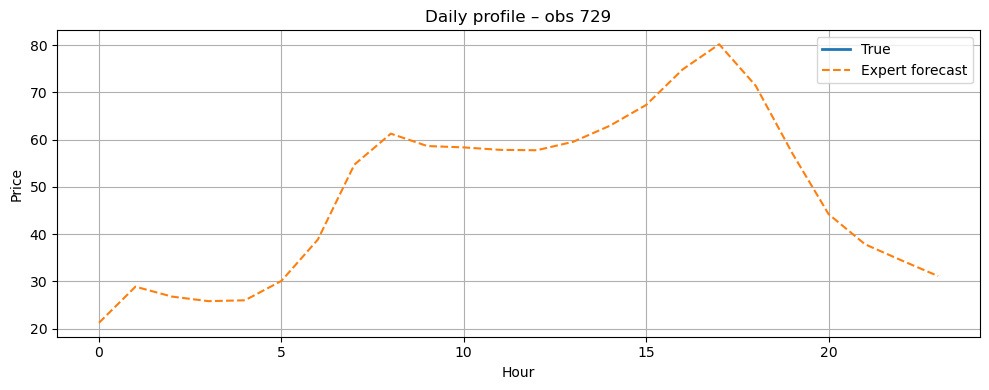

In [12]:
# 9. Plotting. Tutorial 1

test_dates = dates_s[-forecasts.shape[0]:] 

plot_hour_comparison(
    forecasts  = forecasts,
    hour       = 14,
    test_dates = test_dates)

plot_daily_profile(
    forecasts,
    obs_index = forecasts.shape[0] - 1)

In [110]:
# 10. Tutorial 2 


# 1) Build multi-window expert forecasts on the evaluation block
forecasts_eval = build_multiwindow_experts(
    data_t     = data_t,
    dates_s    = dates_s,
    reg_names  = reg_names,
    window_sizes = {1:186, 2:365, 3:730},
    forecast_days = 2*365,    
)

# 2) Tune η per hour
eta_star = tune_ewa_eta(forecasts_eval)

# 3) Build expert forecasts on the *long* test period
forecasts_test = build_multiwindow_experts(
    data_t      = data_t,
    dates_s     = dates_s,
    reg_names   = reg_names,
    window_sizes= {1:186, 2:365, 3:730},
    start_offset= 0,                
    forecast_days = int(2.25*365),  
)

# 4) Aggregate with hour-specific EWA
agg_preds, agg_sq, burn_period = ewa_aggregate_forecasts(
    forecasts_test, eta_star
)

# 5) Assemble tensor [true, D186, D365, D730, combined] & drop burn
forecast_all = torch.cat(
    [forecasts_test,
     agg_preds.unsqueeze(2)], dim=2)[-burn_period:]

model_names = ["true","D_186","D_365","D_730","combined"]

building experts … 100.0% done
building experts … 100.0% done


(24, 4)
0
Hours with no valid RMSE: []


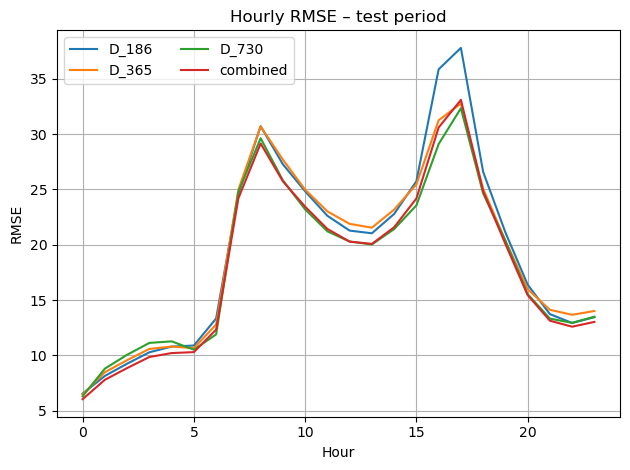

          D_186      D_365      D_730   combined
RMSE  21.297427  20.675114  19.767193  19.788750
MAE   12.710819  12.728947  12.356825  11.687612


In [ ]:
# 6) Error summary + hourly RMSE curve
err_table = compute_error_table(forecast_all, model_names)
print(err_table)

In [ ]:
# Missing data: take care later (ignore or fill-in)

print(torch.isnan(forecasts_eval[:, :, 1:]).all())   # tensor(False)
print(np.isnan(forecasts_test[...,0].cpu()).sum())   # tensor(23)

where = np.where(np.isnan(forecasts_test[...,0])) 
print(f'location of NaN: {where}')

print(forecasts_eval.isnan().sum()) # tensor(23)
print(forecasts_test.isnan().sum()) # tensor(23)


tensor(False)
tensor(23)
location of NaN: (array([820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820,
       820, 820, 820, 820, 820, 820, 820, 820, 820, 820]), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23]))
tensor(23)
tensor(23)


In [ ]:
# Missing data: take care later (ignore or fill-in)

arr = forecasts_test[..., 0].cpu().numpy()
df_nan = pd.DataFrame(arr)
print(df_nan.isna().sum().sum(), "NaN values")
df_nan.to_csv("./data/nan_forecasts_test.csv", index=False)


true_test = forecasts_test[..., 0].cpu().numpy()      # shape (822, 24)
print(true_test.shape)

nan_per_hour = np.isnan(true_test).sum(0)
print("NaNs by hour:", nan_per_hour)                  

rows, cols = np.where(np.isnan(true_test))
unique_rows = np.unique(rows)
print("Day indices with NaNs:", unique_rows)          

bad_idx = unique_rows[0]
print("Dates for the bad day:", dates_s.iloc[-822 + bad_idx])  # map to calendar date
print(pd.Series(true_test[bad_idx], index=range(24)))

In [ ]:
# Missing data: take care later (ignore or fill-in)

arr = forecasts_eval[..., 0].cpu().numpy()
df_nan = pd.DataFrame(arr)
print(df_nan.isna().sum().sum(), "NaN values")
df_nan.to_csv("./data/nan_forecasts_eval.csv", index=False)

23 NaN values


[I 2025-06-04 16:18:18,466] A new study created in memory with name: no-name-3d269cbc-07a4-486c-9d4b-c07f5823c745
[I 2025-06-04 16:18:43,377] Trial 0 finished with value: 19.966863155399036 and parameters: {'D': 452}. Best is trial 0 with value: 19.966863155399036.
[I 2025-06-04 16:19:12,633] Trial 1 finished with value: 19.954233079102888 and parameters: {'D': 470}. Best is trial 1 with value: 19.954233079102888.
[I 2025-06-04 16:19:41,114] Trial 2 finished with value: 21.112356459335224 and parameters: {'D': 329}. Best is trial 1 with value: 19.954233079102888.
[I 2025-06-04 16:20:09,535] Trial 3 finished with value: 21.18013775847441 and parameters: {'D': 318}. Best is trial 1 with value: 19.954233079102888.
[I 2025-06-04 16:20:34,899] Trial 4 finished with value: 21.23468727997649 and parameters: {'D': 301}. Best is trial 1 with value: 19.954233079102888.
[I 2025-06-04 16:21:27,666] Trial 5 finished with value: 19.768452496985958 and parameters: {'D': 707}. Best is trial 5 with val

Best window length D: 718
test tensor shape: torch.Size([730, 24, 2])


<Axes: title={'center': 'Daily profile – obs 729'}, xlabel='Hour', ylabel='Price'>

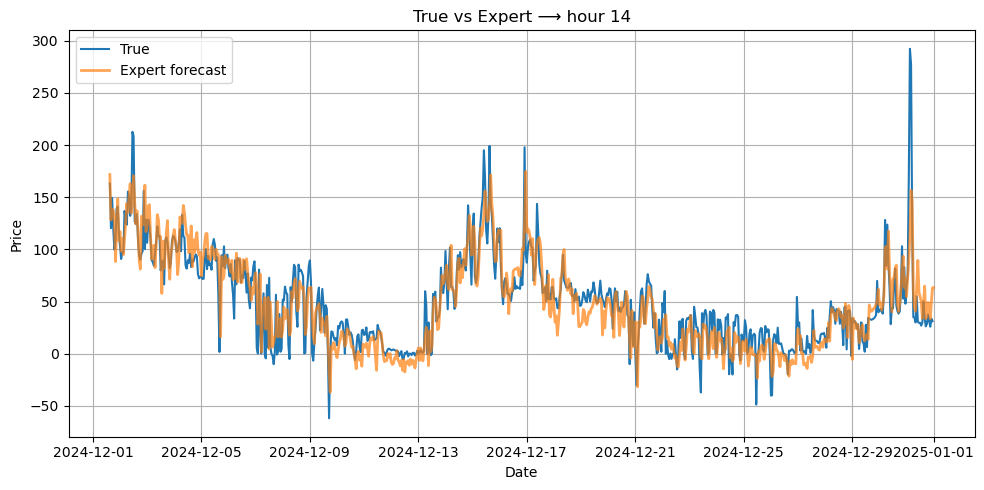

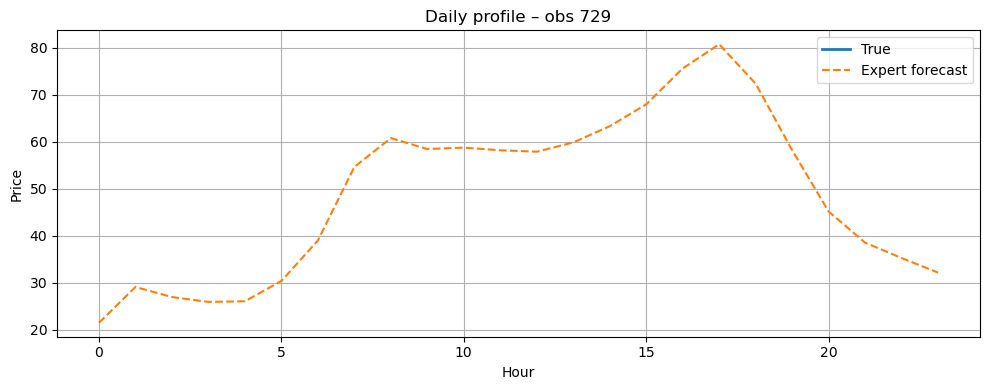

In [ ]:
# 11. Tutorial 3: Hyperparameter tuning with Optuna

# 1)  Hyper-parameter tuning on the 730-day eval window
best_D, study = tune_expert_window(
    data_t    = data_t,
    dates_s   = dates_s,
    reg_names = reg_names,
    eval_days = 2*365,
    window_bounds = (186, 730),
    n_trials  = 50,
)
print("Best window length D:", best_D)

# 2)  Forecast on a 2-year test horizon with the tuned window
forecasts_test = run_expert_window_test(
    data_t    = data_t,
    dates_s   = dates_s,
    reg_names = reg_names,
    window    = best_D,
    test_days = 730,
)

print("test tensor shape:", forecasts_test.shape)  # (730, 24, 2)

In [ ]:
# 11. Plot after Optuna tuning

plot_hour_comparison(
    forecasts  = forecasts_test,
    hour       = 14,
    test_dates = dates_s[-forecasts_test.shape[0]:],
)

plot_daily_profile(
    forecasts_test,
    obs_index = forecasts_test.shape[0]-1,
)

In [ ]:
# RMSE before and after Optuna tuning

true_vals = forecast_all[..., 0].cpu().numpy()
pred_vals = forecast_all[..., -1].cpu().numpy()

mse = np.nanmean((pred_vals - true_vals)**2)
rmse_before = np.sqrt(mse)
print(f"RMSE before Optuna: {rmse_before:.4f}")

true_vals_opt = forecasts_test[..., 0].cpu().numpy()
pred_vals_opt = forecasts_test[..., 1].cpu().numpy()

mse_opt = np.nanmean((pred_vals_opt - true_vals_opt)**2)
rmse_after = np.sqrt(mse_opt)
print(f"RMSE after Optuna: {rmse_after:.4f}")

In [ ]:
# 12. Tutorial 4. Reg Matrix and simple MLP Benchmark

# 7. Transform merged dataset using DST_trafo and prepare training data.
data_t, train_t, train_dates, price_t = prepare_dataset_tensor(
    "./data/data_no1.csv",
    tz="CET",
    seed=42,
    test_days=2*365,         
    dtype=torch.float64, 
)
print(train_t.shape, price_t.shape)

# 1) Build regression matrix for the evaluation block
reg_data = build_regression_matrix(
    dat_eval = train_t.cpu().numpy(),
    days_eval= pd.to_datetime(train_dates),
    reg_names= df.columns[1:],   # all columns except time_utc
)

# 2) Prepare tensors for the FIRST evaluation day
tensors = prepare_train_test_tensors(
    regmat_df   = reg_data["regmat"],
    dep_indices = reg_data["dep_indices"],
    D           = 730,                      # window
    eval_start_row = reg_data["regmat"].shape[0] - 730,   # begin_eval
    device      = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)

# 3) Train the MLP and get prediction vs. true
pred, true = train_mlp(
    tensors,
    hidden_dim   = 50,
    lr           = 0.001,
    weight_decay = 0.001,
    batch_size   = 32,
    epochs       = 60,
)

print("Predicted price (all 24 series) :", pred.numpy())
print("True price       (all 24 series) :", true.numpy())

# scalar metrics for that single-day, 24-hour vector
rmse = torch.sqrt(((pred - true) ** 2).mean()).item()
mae  = (pred - true).abs().mean().item()
print(f"MLP 1-day RMSE: {rmse:.3f}  MAE: {mae:.3f}")

torch.Size([1463, 24, 10]) torch.Size([1463, 24])
Predicted price (all 24 series) : [[37.77379  35.861824 38.08127  36.624527 40.385384 39.725006 41.275936
  45.48896  48.638573 50.044945 45.445282 49.716946 45.401222 45.11915
  46.19912  43.630013 51.067917 51.334755 46.418865 45.257256 41.771584
  39.221577 42.99498  39.272118]]
True price       (all 24 series) : [[33.03 32.43 31.58 30.84 31.68 36.81 41.87 46.21 56.14 47.71 46.23 43.82
  41.22 40.04 39.47 41.17 45.91 55.49 54.51 48.1  47.14 40.88 40.02 38.03]]
MLP 1-day RMSE: 4.771  MAE: 4.161


In [ ]:
# 13. Tutorial 5. MLP  — rolling-window expert + Optuna tuning

# -------------------------------------------------------------
# 0) Regression matrix on *all* data (no NaNs)
reg_data = build_regression_matrix(
    dat_eval = train_t.cpu().numpy(),
    days_eval= pd.to_datetime(train_dates),
    reg_names= df.columns[1:],   # all columns except time_utc
)
reg_df   = reg_data["regmat"].dropna().reset_index(drop=True)
dep_idx  = reg_data["dep_indices"]

# -------------------------------------------------------------
# 1)  Optuna tuning on a 730-day evaluation block
eval_start  = reg_df.shape[0] - 730          # first eval row
best_params, study = tune_mlp_hyperparameters(
    reg_df, dep_idx, eval_window = (eval_start, 730), n_trials = 40
)
print("best params:", best_params)

# -------------------------------------------------------------
# 2)  Build rolling forecasts on a 730-day *test* block
test_horizon = 730
test_start   = reg_df.shape[0] - test_horizon
preds_mlp, trues_mlp = build_mlp_rolling_forecasts(
    reg_df, dep_idx,
    window      = best_params["D"],
    horizon     = test_horizon,
    start_row   = test_start,
    hidden_dim  = best_params["hidden"],
    lr          = best_params["lr"],
    weight_decay= best_params["wd"],
)

In [ ]:
# -------------------------------------------------------------
# 3)  Append to forecast_all and compute error table
mlp_chan  = preds_mlp.unsqueeze(2)            # (N,24,1)
forecast_all = torch.cat([forecast_all, mlp_chan], dim=2)
model_names  = model_names + ["MLP"]

err_table_with_mlp = compute_error_table(forecast_all, model_names)
print(err_table_with_mlp)
